In [1]:
!pip install requests==2.32.4

In [2]:
!pip install --upgrade langchain
!pip install --upgrade langchain-community

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
!pip install langchain-groq

In [4]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('groqapikey')

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [6]:
from typing_extensions import TypedDict

In [7]:
!pip install langgraph

In [8]:
from langchain_core.prompts import ChatPromptTemplate

In [9]:
class State(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str

In [10]:
from langgraph.graph import StateGraph, START, END
workflow = StateGraph(State)

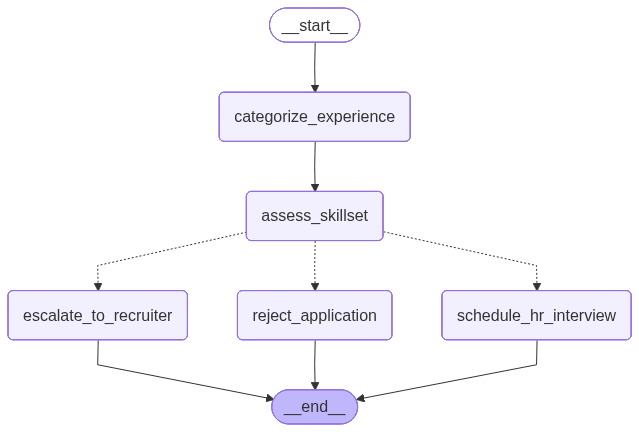

In [11]:
def extract_level(llm_text: str) -> str:
    text = llm_text.lower()
    if "senior" in text:
        return "senior-level"
    if "mid" in text:
        return "mid-level"
    if "entry" in text:
        return "entry-level"
    return "unknown"

def extract_skill_match(llm_text: str) -> str:
    text = llm_text.lower()
    if "match" in text and "no" not in text:
        return "match"
    return "no match"

def categorize_experience(state: State) -> State:
    print("\nCategorizing the experience level of candidate:")

    prompt = ChatPromptTemplate.from_template(
        "Based on the following job application, categorize the candidate strictly as "
        "'Entry-level', 'Mid-level', or 'Senior-level'.\n"
        "Response must only contain the level.\n\n"
        "Application:\n{application}"
    )
    chain = prompt | llm
    raw_output = chain.invoke({"application": state["application"]}).content
    level = extract_level(raw_output)

    print(f"Experience Level (clean): {level}")
    return {"experience_level": level}

def assess_skillset(state: State) -> State:
    print("\nAssessing the skillset of candidate:")

    prompt = ChatPromptTemplate.from_template(
        "For a Python Developer job, does the candidate match required skills? "
        "Respond ONLY with 'Match' or 'No Match'.\n\nApplication:\n{application}"
    )
    chain = prompt | llm
    raw_output = chain.invoke({"application": state["application"]}).content

    skill = extract_skill_match(raw_output)

    print(f"Skill Match (clean): {skill}")
    return {"skill_match": skill}

def schedule_hr_interview(state: State) -> State:
    print("\nScheduling the interview:")
    return {"response": "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
    print("Escalating to recruiter")
    return {"response": "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
    print("Sending rejecting email")
    return {"response": "Candidate doesn't meet JD and has been rejected."}

workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

def route_app(state: State) -> str:
    skill = state["skill_match"].strip().lower()
    level = state["experience_level"].strip().lower()

    if skill == "match":
        return "schedule_hr_interview"
    elif level == "senior-level":
        return "escalate_to_recruiter"
    else:
        return "reject_application"

workflow.add_edge(START, "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges(
    "assess_skillset",
    route_app,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recruiter": "escalate_to_recruiter",
        "reject_application": "reject_application"
    }
)
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [13]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate:
Experience Level (clean): senior-level

Assessing the skillset of candidate:
Skill Match (clean): no match
Escalating to recruiter


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: senior-level
Skill Match: no match
Response: Candidate has senior-level experience but doesn't match job skills.


In [14]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate:
Experience Level (clean): entry-level

Assessing the skillset of candidate:
Skill Match (clean): no match
Sending rejecting email


Computed Results :
Application: I have 1 year of experience in software engineering with expertise in JAVA
Experience Level: entry-level
Skill Match: no match
Response: Candidate doesn't meet JD and has been rejected.


In [15]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate:
Experience Level (clean): mid-level

Assessing the skillset of candidate:
Skill Match (clean): match

Scheduling the interview:


Computed Results :
Application: I have experience in software engineering with expertise in Python
Experience Level: mid-level
Skill Match: match
Response: Candidate has been shortlisted for an HR interview.
